<a href="https://colab.research.google.com/github/meetcfd/PINN_1D_Heat_transfer/blob/main/1D_PINN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as  plt
import pandas as pd
import sympy as sp
from scipy.sparse import diags

from tensorflow import keras
from tensorflow.keras import Model, layers
from tensorflow.keras.callbacks import LearningRateScheduler
from keras.utils.vis_utils import plot_model

# PDE: du/dt - d2u/dx2 = 0
# IC: u(x,0) = sin(x)
# BC: u(-pi,t) = u(pi,t) = 0
# x = (-pi,pi) ; t = (0,1)

## Initial Conditions


In [ ]:
X = tf.linspace(-np.pi, np.pi, 200)
t = tf.zeros(X.shape)
y = tf.math.sin(X)

sample_num = 100 
t_sim = tf.linspace(0,1,sample_num)
t_sim = tf.cast(t_sim, tf.float32)

## Interior (Collocation) Points

In [ ]:
def rid_gen(seed, X, sample_num): # randomly sampling the space/time domain
  tf.random.set_seed(seed)
  sample_num = sample_num
  idxs = tf.range(2, tf.shape(X)[0]-1)
  ridxs = tf.random.shuffle(idxs)[:sample_num]
  return tf.gather(X, ridxs)

# 500 collocation points sampled from (-pi to pi)
X_int1 = rid_gen(42,X,sample_num)
X_int2 = rid_gen(69,X,sample_num)
X_int3 = rid_gen(17,X,sample_num)
X_int4 = rid_gen(7,X,sample_num)
X_int5 = rid_gen(999,X,sample_num)

X_int_list = [X_int1, X_int2, X_int3, X_int4, X_int5]
X_new = tf.concat(X_int_list,axis=0)

# simulation time for 0 to 1 sec and concat it for collocation points
t_new_list = [t_sim, t_sim, t_sim, t_sim, t_sim]
t_new = tf.concat(t_new_list,axis=0)
cc = tf.stack((X_new, t_new), axis=1)

In [ ]:
X_new.shape, t_new.shape

(TensorShape([500]), TensorShape([500]))

## Boundary Conditions

In [ ]:
X_bc = tf.concat([X[0] * tf.ones(int(X.shape[0]/4)), X[-1] * tf.ones(int(X.shape[0]/4))],axis=0) 
# 100 boundary points along with randomly sampled time points from (0, 1)

bc_num_sample = 50
t_bc1 = rid_gen(1234, t_sim, bc_num_sample)
t_bc2 = rid_gen(4321, t_sim, bc_num_sample)
t_bc = tf.concat([t_bc1,t_bc2],axis=0)
bc = tf.stack((X_bc, t_bc), axis=1)

In [ ]:
X_bc.shape, t_bc.shape

(TensorShape([100]), TensorShape([100]))

## Training Data 

In [ ]:
training_data = tf.stack([X, t], axis=1)

Text(0, 0.5, 'space')

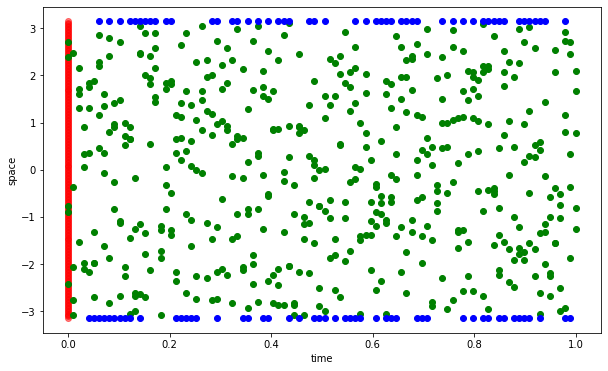

In [ ]:
# Visualizing the space-time domain
plt.figure(figsize=(10,6))
plt.scatter(training_data[:,1].numpy(), training_data[:,0].numpy(),c='red',alpha=0.5);
plt.scatter(cc[:,1].numpy(), cc[:,0].numpy(),c='green');
plt.scatter(bc[:,1].numpy(), bc[:,0].numpy(),c='blue');
plt.xlabel("time")
plt.ylabel("space")

## PINN using Model subclassing 

In [ ]:
class MyModel(Model):
    # using 3 dense layers for (n1, n2, 1)
    def __init__(self,cc,bc,num_channels):
        super(MyModel,self).__init__()
        self.dense = layers.Dense(num_channels[0])
        self.dense2 = layers.Dense(num_channels[1])    
        self.dense3 = layers.Dense(1)
        self.X_cc = cc[:,0]
        self.t_cc = cc[:,1]
        self.X_bc = bc[:,0]
        self.t_bc = bc[:,1]

    # functional form of the neural network
    def call(self, input_tensor):
        x = self.dense(input_tensor)
        x = tf.nn.silu(x)
        x = self.dense2(x)
        x = tf.nn.silu(x)
        return self.dense3(x)

    # Just for printing out model.summary (see the next cell)
    def model(self, input):
        X = tf.stack([input[:,0],input[:,1]], axis=1)
        x = layers.Input(shape=(X.shape))
        return Model(inputs=[x], outputs=self.call(x))

    # PDE using auto diff 
    @tf.function
    def f_model(self):

        with tf.GradientTape(persistent= True) as tape:
            tape.watch(self.X_cc)
            tape.watch(self.t_cc)

            X = tf.stack([self.X_cc,self.t_cc], axis=1)

            u = self.call(X)

            df_dx = tape.gradient(u,self.X_cc)
        
        d2f_dx2 = tape.gradient(df_dx,self.X_cc)

        df_dt = tape.gradient(u,self.t_cc)

        pde = (df_dt - d2f_dx2)  # collocation points

        del tape

        return pde

    # PDE loss (MSE of pde at collocation points (red points)) from 200 to 700 points
    @tf.function    
    def loss_pde(self,y,y_pred):

            pde = self.f_model()
            pdel = tf.reduce_mean(tf.square(pde))
            return pdel

    # BC loss (MSE of boundary conditions at boundary points (blue points)) the last 100 points of training data
    @tf.function        
    def loss_bc(self,y,y_pred):

            X = tf.stack([self.X_bc,self.t_bc], axis=1)
            pred = self.call(X)
            bcl = tf.reduce_mean(tf.square(pred))
            return bcl

    # IC loss (MSE of initial conditions at inital points (green points)) the first 200 points of training data
    @tf.function        
    def loss_ic(self,y,y_pred):
      
            icl =  tf.reduce_mean((tf.square(tf.math.subtract(y_pred , y))))
            return icl

    # Total loss (Summing the MSE losses)
    @tf.function    
    def total_loss(self,y,y_pred):

            # pde = model.f_model()
            pdel = self.loss_pde(y,y_pred)
            icl =  self.loss_ic(y,y_pred)
            bcl =  self.loss_bc(y,y_pred)
            return pdel + icl + bcl

## Initializing the model with 5, 5 layers

In [ ]:
tf.random.set_seed(42)
model = MyModel(cc,bc,[5,5])
model.model(training_data).summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 2)]          0         
                                                                 
 dense (Dense)               (None, 200, 5)            15        
                                                                 
 tf.nn.silu (TFOpLambda)     (None, 200, 5)            0         
                                                                 
 dense_1 (Dense)             (None, 200, 5)            30        
                                                                 
 tf.nn.silu_1 (TFOpLambda)   (None, 200, 5)            0         
                                                                 
 dense_2 (Dense)             (None, 200, 1)            6         
                                                                 
Total params: 51
Trainable params: 51
Non-trainable params: 0

## Compiling and Fitting the model 

In [ ]:
model.compile(loss= model.total_loss,
            optimizer= keras.optimizers.Adam(learning_rate=1e-3)
            ,metrics=[model.loss_ic, model.loss_pde, model.loss_bc])

# batch size =  size of the training data because how it is structured
hist = model.fit(training_data,y,epochs=1000,batch_size=32,verbose=0)

## Plotting the losses 

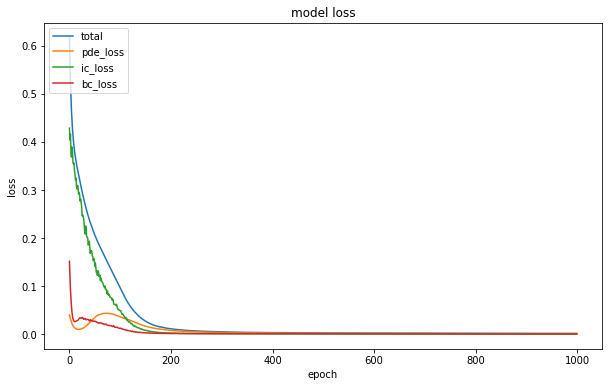

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(hist.history['loss'])
plt.plot(hist.history['loss_pde'])
plt.plot(hist.history['loss_ic'])
plt.plot(hist.history['loss_bc'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['total','pde_loss','ic_loss','bc_loss'], loc='upper left')
plt.show()

## Plotting the model results at 0.1, 0.2, ... 1

7/7 [==============================] - 0s 2ms/step


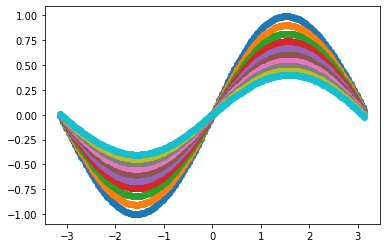

In [ ]:
for i in range(0,100,10): 
  test_time = t_sim[i]
  t = test_time*tf.ones(X.shape)
  data_test = tf.stack([X,t],axis=1)
  y_pred = model.predict(data_test)
  plt.scatter(data_test[:,0], tf.squeeze(y_pred));


##  Finite Difference Model 1D Heat , change t_max for checking other solution

In [ ]:
dt = 5e-4
dy = 5e-2
k = 1
y_min = -np.pi
y_max = np.pi
t_max = 0.5
T0 = 0

def Implicit(dt,dy,t_max,y_max,y_min,k,T0):
    s = k*dt/dy**2
    y = np.arange(y_min,y_max+dy,dy) 
    r = int(t_max/dt)
    c = len(y)
    T = np.zeros([c])
    T[:] = np.sin(y)
    T[0] = T0
    T[-1] = T0
    b = T

    coeff_mat_diag = (1. + 2*s)*np.ones([c])
    coeff_mat_neigh = -s*np.ones([c])
    pos = [-1, 0, 1]
    data = [coeff_mat_neigh.tolist(), coeff_mat_diag.tolist(), coeff_mat_neigh.tolist()]

    coeff_mat = diags(data, pos, [c,c])
    coeff_mat = coeff_mat.toarray()

    for _ in range(r):
        T = np.linalg.solve(coeff_mat, b)
        b = T
        b[0] = T0
        b[-1] = T0
        # if _ % r-1 == 0:
        #    plt.scatter(np.arange(y_min,y_max+dy,dy),T,alpha=0.3);
    return T


## Difference between the real solution (red) (ground truth) and model solution (blue) @ t = 0.5

7/7 [==============================] - 0s 3ms/step


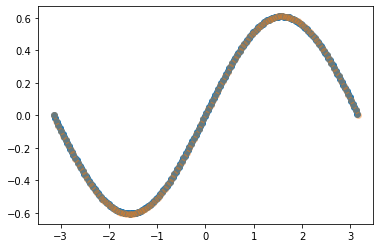

In [ ]:
for i in [0.5]: 
  test_time = i
  t = test_time*tf.ones(X.shape)
  data_test = tf.stack([X,t],axis=1)
  y_pred = model.predict(data_test)
  plt.scatter(data_test[:,0], tf.squeeze(y_pred));

T = Implicit(dt,dy,t_max,y_max,y_min,k,T0)
plt.scatter(np.arange(y_min,y_max+dy,dy),T,alpha=0.3);